In [1]:
!pip install -q transformers
!wget https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar
!tar -xvf ./scibert_scivocab_uncased.tar

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
--2020-08-24 01:50:39--  https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.192.144
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.192.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442460160 (422M) [application/x-tar]
Saving to: ‘scibert_scivocab_uncased.tar’

scibert_scivocab_un 100%[===================>] 421.96M  22.8MB/s    in 15s     

2020-08-24 01:50:55 (28.6 MB/s) - ‘scibert_scivocab_uncased.tar’ saved [442460160/442460160]

scibert_scivocab_uncased/
scibert_scivocab_uncased/vocab.txt
scibert_scivocab_uncased/pytorch_model.bin
scibert_scivocab_uncased/config.json


In [2]:
!pip install -q langdetect
!pip install -q googletrans
from googletrans import Translator
from langdetect import detect

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/researchtopictagaugwithoutlatextags/sample.csv
/kaggle/input/researchtopictagaugwithoutlatextags/test_aug_without_latex_tags.csv
/kaggle/input/researchtopictagaugwithoutlatextags/train_aug_without_latex_tags.csv
/kaggle/input/researchtopictagaug/test_aug_with_latex_tags.csv
/kaggle/input/researchtopictagaug/sample.csv
/kaggle/input/researchtopictagaug/train_aug_with_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/test_without_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/train_without_latex_tags.csv
/kaggle/input/researchtopictagwithoutlatex/sample.csv
/kaggle/input/researchtopictags/test.csv
/kaggle/input/researchtopictags/train.csv
/kaggle/input/researchtopictags/sample.csv


In [4]:
import numpy as np
import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import random 
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score

# fastai
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
import transformers
from transformers import *
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from fastai.callbacks import *
from transformers import AdamW
from functools import partial

import re

print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 2.11.0


In [5]:
train_data = pd.read_csv('/kaggle/input/researchtopictags/train.csv')
test_data = pd.read_csv('/kaggle/input/researchtopictags/test.csv')  

In [6]:
print(train_data.shape)
train_data.head()

(20972, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [7]:
print(test_data.shape)
test_data.head()

(8989, 3)


,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [8]:
train_data['combined_text'] = train_data['TITLE'] + " <join> " + train_data['ABSTRACT']
test_data['combined_text'] = test_data['TITLE'] + " <join> " + test_data['ABSTRACT']

In [9]:
topics = ['Computer Science','Physics','Mathematics', 'Statistics','Quantitative Biology','Quantitative Finance']

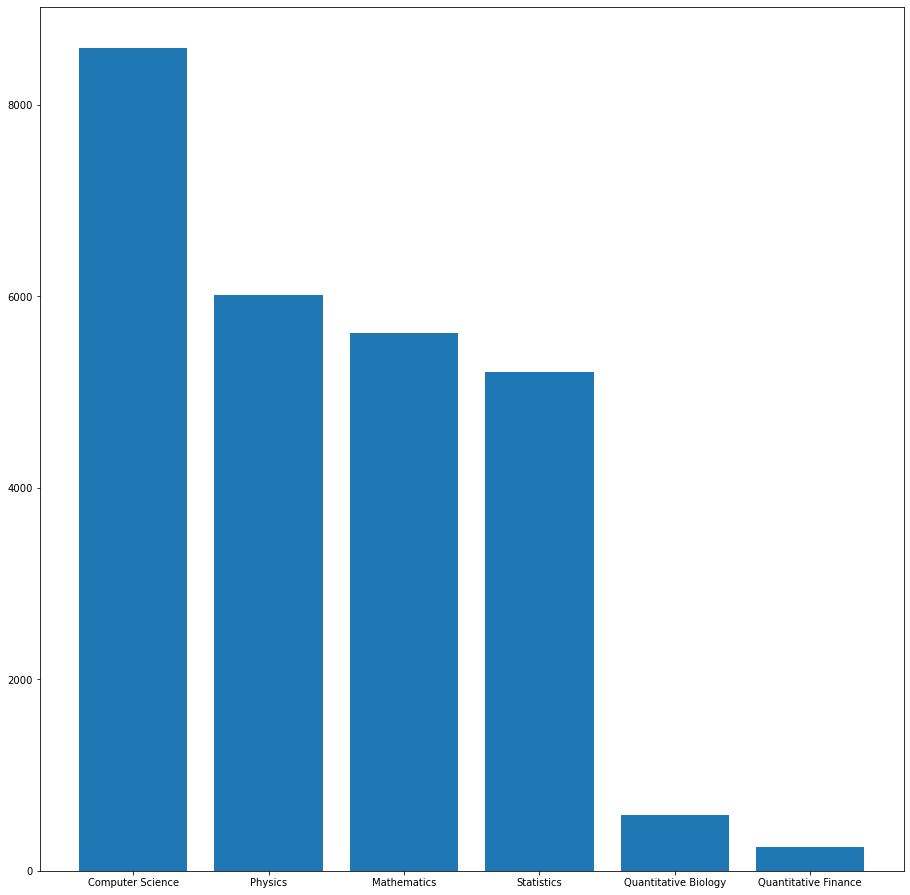

In [10]:
com_sc = train_data['Computer Science'].value_counts()[1]
phy = train_data['Physics'].value_counts()[1]
mat = train_data['Mathematics'].value_counts()[1]
stats = train_data['Statistics'].value_counts()[1]
bio = train_data['Quantitative Biology'].value_counts()[1]
fin = train_data['Quantitative Finance'].value_counts()[1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [com_sc,phy,mat,stats,bio,fin]
ax.bar(topics,counts)
plt.show()

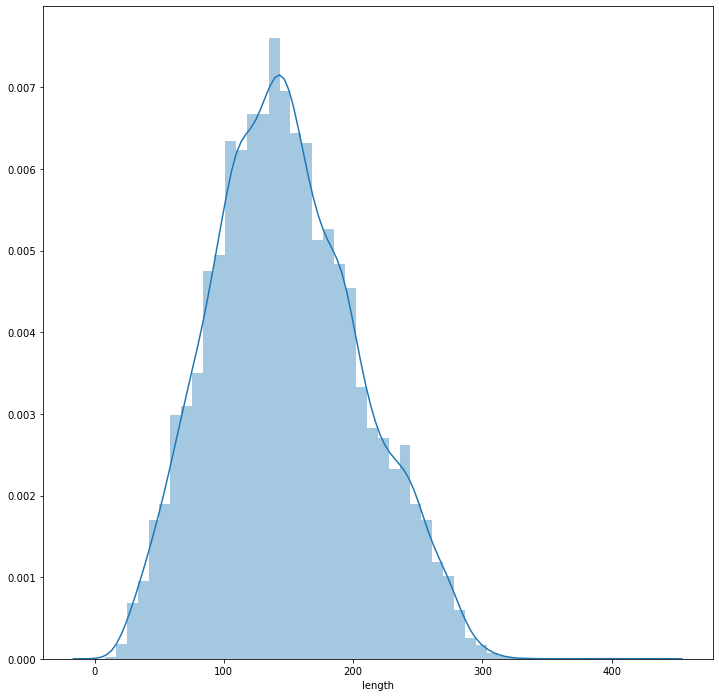

In [11]:
train_data['length'] = train_data['combined_text'].apply(lambda x : x.count(" ") + 1)
sns.distplot(train_data['length'])

In [12]:
SciBertTokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

SciBertModel = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

In [13]:
MODEL_CLASSES = {'scibert' : (SciBertModel, SciBertTokenizer, PretrainedConfig.from_json_file('./scibert_scivocab_uncased/config.json'))}

In [14]:
# Parameters

seed = 42

use_fp16 = False

bs = 16

threshold = 0.4

MAX_LEN = 320

model_type = 'scibert'

pretrained_model_name = 'allenai/scibert_scivocab_uncased'

In [15]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [16]:
def seed_all(seed_value):
    
    random.seed(seed_value) # Python
    
    np.random.seed(seed_value) # cpu vars
    
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        
        torch.cuda.manual_seed(seed_value)
        
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        
        torch.backends.cudnn.deterministic = True  #needed
        
        torch.backends.cudnn.benchmark = False

In [17]:
seed_all(seed)

In [18]:
class TransformersBaseTokenizer(BaseTokenizer):
    
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', max_len = MAX_LEN,**kwargs):
        
        self._pretrained_tokenizer = pretrained_tokenizer
        
        self.max_seq_len = max_len
        
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        
        return self

    def tokenizer(self, t:str) -> List[str]:
        
        """Limits the maximum sequence length and add the special tokens"""
        
        CLS = self._pretrained_tokenizer.cls_token
        
        SEP = self._pretrained_tokenizer.sep_token
        
        tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        
        tokens = [CLS] + tokens + [SEP]
        
        return tokens

In [19]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)

transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [20]:
class TransformersVocab(Vocab):
    
    def __init__(self, tokenizer: PreTrainedTokenizer):
        
        super(TransformersVocab, self).__init__(itos = [])
        
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        
        "Convert a list of tokens `t` to their ids."
        
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        
        "Convert a list of `nums` to their tokens."
        
        nums = np.array(nums).tolist()
        
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        
        self.itos = state['itos']
        
        self.tokenizer = state['tokenizer']
        
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [21]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [22]:
pad_first = False

pad_idx = transformer_tokenizer.pad_token_id

In [23]:
data_classifier = (TextList.from_df(train_data, cols='combined_text', processor=transformer_processor)
                         .split_by_rand_pct(0.3,seed=seed)
                         .label_from_df(cols= topics)
                         .add_test(test_data)
                         .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [24]:
data_classifier.save('data_classifier.pkl')

In [25]:
data_classifier = load_data('','data_classifier.pkl',bs=bs)

In [26]:
print('[CLS] token :', transformer_tokenizer.cls_token)

print('[SEP] token :', transformer_tokenizer.sep_token)

print('[PAD] token :', transformer_tokenizer.pad_token)

data_classifier.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] prediction of stable ground - state lithium poly ##hydr ##ides under high pressures < join > hydrogen - rich compounds are important for understanding the dissociation of dense molecular hydrogen , as well as searching for room temperature bar ##de ##en - cooper - schr ##ief ##fer ( bcs ) superconduc ##tors . a recent high pressure experiment reported the successful synthesis of novel ins ##ulating lithium poly ##hydr",Physics
"[CLS] neural networks as interacting particle systems : asymptotic convexity of the loss landscape and universal scaling of the approximation error < join > neural networks , a central tool in machine learning , have demonstrated remarkable , high fidelity performance on image recognition and classification tasks . these success ##es ev ##inc ##e an ability to accurately represent high dimensional functions , potentially of great use in computational and",Statistics
"[CLS] intrinsically sparse long short - term memory networks < join > long short - term memory ( ls ##tm ) has achieved state - of - the - art performances on a wide range of tasks . its outstanding performance is guaranteed by the long - term memory ability which matches the sequential data perfectly and the gating structure controlling the information flow . however , ls ##tm ##s",Computer Science
[CLS] high - $ t _ \ text ##rm { c } $ superconduc ##tivity in cs $ _ 3 $ c $ _ { 60 } $ compounds governed by local cs - c $ _ { 60 } $ coulomb interactions < join > unique among alkali - doped $ \ text ##it { a } $ $ _ 3 $ c $ _ { 60 } $,Physics
"[CLS] autonomous dro ##ne race : a computationally efficient vision - based navigation and control strategy < join > dro ##ne rac ##ing is becoming a popular sport where human pilot ##s have to control their dro ##nes to fly at high speed through complex environments and pass a number of gates in a pre - defined sequence . in this paper , we develop an autonomous system for dro",Computer Science


In [27]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)

print('[SEP] id :', transformer_tokenizer.sep_token_id)

print('[PAD] id :', pad_idx)

test_one_batch = data_classifier.one_batch()[0]

print('Batch shape : ',test_one_batch.shape)

print(test_one_batch)

[CLS] id : 102
[SEP] id : 103
[PAD] id : 0
Batch shape :  torch.Size([16, 320])
tensor([[  102,   130,  2409,  ...,   165,   111,   103],
        [  102,  1913,   954,  ...,  1045,   422,   103],
        [  102,  3250,  2320,  ...,  7901, 11901,   103],
        ...,
        [  102,  3306,  4324,  ...,   111, 17987,   103],
        [  102,   722,   499,  ...,   106,  1211,   103],
        [  102,  3532,   131,  ...,   555,   188,   103]])


In [28]:
# defining our model architecture 

class CustomTransformerModel(nn.Module):
    
    def __init__(self, transformer_model: PreTrainedModel):
        
        super(CustomTransformerModel,self).__init__()
        
        self.transformer = transformer_model
        
        self.classifier = nn.Sequential(#nn.Linear(in_features=768, out_features=768, bias=True),
                                        #nn.Dropout(p=0.1, inplace=False),
                                        nn.Linear(in_features=768, out_features=6, bias=True))
        
    def forward(self, input_ids, attention_mask=None):
        
   
        outputs = self.transformer(input_ids,
                                  attention_mask = attention_mask)
        
        pooled_output = outputs[1]
        
        logits = self.classifier(pooled_output)
        
        return logits

In [29]:
config = config_class.from_pretrained(pretrained_model_name)

config.num_labels = 6

config.use_bfloat16 = use_fp16

print(config)

PretrainedConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 31090
}



In [30]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Learner : Custom Metric

In [31]:
class MicroF1(Callback):

    _order = -20 #is crucial - without it the custom columns will not be added - it tells the callback system to run this callback before the recorder system.

    def __init__(self,learn,thresh,eps = 1e-15, sigmoid = True,**kwargs):
        
        self.learn = learn
        
        self.thresh = thresh
        
        self.eps = eps
        
        self.sigmoid = sigmoid

    def on_train_begin(self, **kwargs): 
        
        self.learn.recorder.add_metric_names(['MicroF1'])
    
    def on_epoch_begin(self, **kwargs):
        
        self.tp = 0
        
        self.total_pred = 0
        
        self.total_targ = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        
        pred, targ = ((last_output.sigmoid() if self.sigmoid else last_output) > self.thresh).byte(), last_target.byte()
        
        if torch.equal(torch.tensor(pred.shape),torch.tensor(targ.shape)):
            
            m = pred*targ
            
            self.tp += m.sum(0).float()
            
            self.total_pred += pred.sum(0).float()
            
            self.total_targ += targ.sum(0).float()
    
    def fbeta_score(self, precision, recall):
        
        return 2*(precision*recall)/((precision + recall) + self.eps)

    def on_epoch_end(self, last_metrics, **kwargs):
        
        self.total_pred += self.eps
        
        self.total_targ += self.eps
        
        precision, recall = self.tp.sum() / self.total_pred.sum(), self.tp.sum() / self.total_targ.sum()
        
        res = self.fbeta_score(precision, recall)        
        
        return add_metrics(last_metrics, res)

In [32]:
class AUCROC(Callback):
    
    _order = -20 
    
    def __init__(self, learn, **kwargs): 
        
        self.learn = learn
        
        self.output, self.target = [], []
        
    def on_train_begin(self, **kwargs): 
        
        self.learn.recorder.add_metric_names(topics)
        
    def on_epoch_begin(self, **kwargs): 
        
        self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        
        if not train:
            
            self.output.append(last_output)
            
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        
        if len(self.output) > 0:
            
            output = torch.cat(self.output)
            
            target = torch.cat(self.target)
            
            preds = F.softmax(output, dim=1)
            
            metric = []

            for i in range(0,target.shape[1]):
                
                
                metric.append(roc_auc_score(target.cpu().numpy()[...,i], preds[...,i].cpu().numpy(),average='macro'))
            
            return add_metrics(last_metrics, metric)
        
        else:
            
            return

In [33]:
microF1 = partial(MicroF1,thresh = threshold) #metric

CustomAdamW = partial(AdamW, correct_bias=False) #optimizer

In [34]:
classifierModel = Learner(data_classifier, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  callback_fns = [microF1,AUCROC],
                  loss_func = nn.BCEWithLogitsLoss()
                 )

# Show graph of learner stats and metrics after each epoch.
classifierModel.callbacks.append(ShowGraph(classifierModel))

In [35]:
print(classifierModel.model)

CustomTransformerModel(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [36]:
#n = len(classifierModel.model.transformer.base_model.encoder.layer)//3

#list_layers = [[classifierModel.model.transformer.base_model.embeddings],
#               list(classifierModel.model.transformer.base_model.encoder.layer[:n]),
#               list(classifierModel.model.transformer.base_model.encoder.layer[n+1:2*n]),
#               list(classifierModel.model.transformer.base_model.encoder.layer[(2*n)+1:]),
#               [classifierModel.model.transformer.base_model.pooler],
#               classifierModel.model.classifier]

In [37]:
list_layers = [classifierModel.model.transformer.base_model.embeddings,
              classifierModel.model.transformer.base_model.encoder.layer[0],
              classifierModel.model.transformer.base_model.encoder.layer[1],
              classifierModel.model.transformer.base_model.encoder.layer[2],
              classifierModel.model.transformer.base_model.encoder.layer[3],
              classifierModel.model.transformer.base_model.encoder.layer[4],
              classifierModel.model.transformer.base_model.encoder.layer[5],
              classifierModel.model.transformer.base_model.encoder.layer[6],
              classifierModel.model.transformer.base_model.encoder.layer[7],
              classifierModel.model.transformer.base_model.encoder.layer[8],
              classifierModel.model.transformer.base_model.encoder.layer[9],
              classifierModel.model.transformer.base_model.encoder.layer[10],
              classifierModel.model.transformer.base_model.encoder.layer[11],
              classifierModel.model.transformer.base_model.pooler]

In [38]:
classifierModel.split(list_layers)

num_groups = len(classifierModel.layer_groups)

print('Learner split in',num_groups,'groups')

print(classifierModel.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(31090, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

In [39]:
classifierModel.save('untrain')

In [40]:
seed_all(seed)

classifierModel.load('untrain');

In [41]:
classifierModel.freeze_to(-1)

In [42]:
classifierModel.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [320, 768]           23,877,120 False     
______________________________________________________________________
Embedding            [320, 768]           393,216    False     
______________________________________________________________________
Embedding            [320, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [320, 768]           1,536      False     
______________________________________________________________________
Dropout              [320, 768]           0          False     
______________________________________________________________________
Linear               [320, 768]           590,592    False     
______________________________________________________________________
Linear               [320, 768]           590,592    False     
_______________________________________

In [43]:
classifierModel.lr_find()

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 7.59E-04


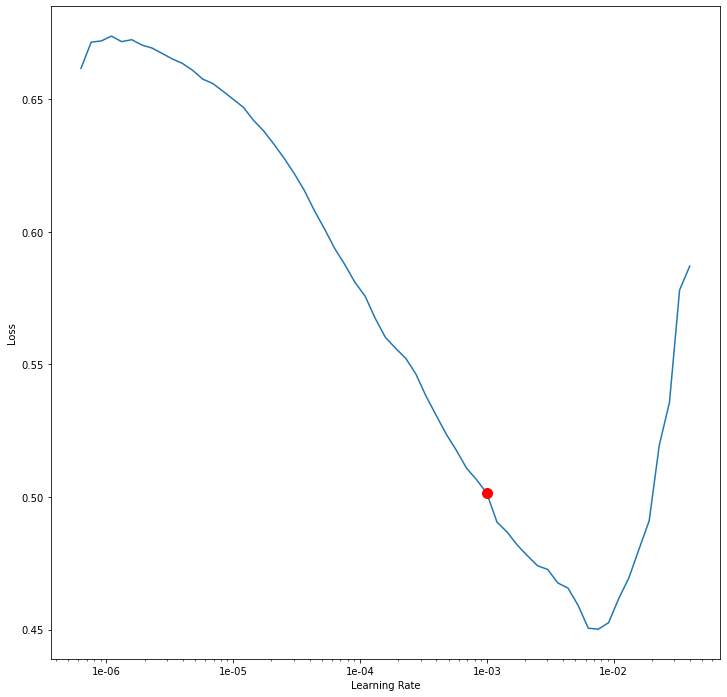

In [44]:
classifierModel.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.305388,0.239303,0.713826,0.935079,0.967001,0.951330,0.879473,0.945170,0.949457,02:53
1,0.291357,0.220787,0.708177,0.934443,0.972123,0.946830,0.934401,0.925433,0.955123,02:55
2,0.253191,0.185572,0.761440,0.937890,0.968023,0.954902,0.927506,0.933434,0.968293,02:49
3,0.229342,0.181530,0.806734,0.937807,0.972806,0.955173,0.936918,0.945540,0.982840,02:41
4,0.219411,0.171953,0.808302,0.939409,0.973670,0.955611,0.940472,0.948990,0.985542,02:45


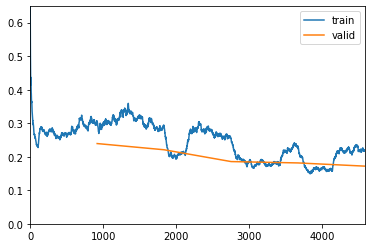

In [45]:
classifierModel.fit_one_cycle(5, max_lr = 3e-3 ,moms=(0.8,0.7))

In [46]:
classifierModel.save('classifierModel1')

In [47]:
seed_all(seed)

classifierModel.load('classifierModel1');

==================================================  Frozen Layer Group 2 ==================================================


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.215746,0.171507,0.819909,0.939947,0.973772,0.955855,0.942056,0.948345,0.986525,02:56


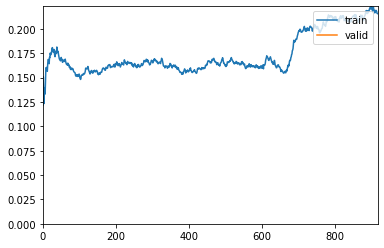


==================================================  Frozen Layer Group 3 ==================================================


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.196715,0.168576,0.806615,0.940241,0.974254,0.955035,0.945489,0.955312,0.989899,03:25


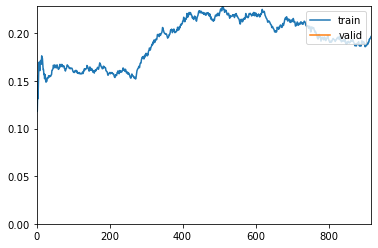


==================================================  Frozen Layer Group 4 ==================================================


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.176751,0.165852,0.825795,0.940651,0.974989,0.954311,0.949441,0.958072,0.990509,03:48


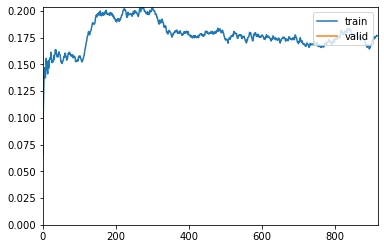


==================================================  Frozen Layer Group 5 ==================================================


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.161195,0.163009,0.835606,0.942518,0.975265,0.956186,0.952048,0.964560,0.992115,04:11


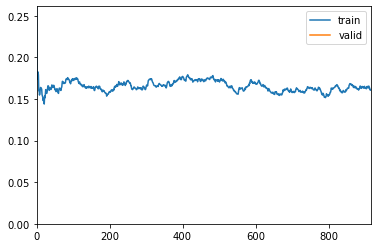

In [48]:
for i in range(2,6):
    
    print('=' * 50, f" Frozen Layer Group {i}", '=' * 50)
    
    classifierModel.freeze_to(-i)
    
    classifierModel.fit_one_cycle(1,slice(1e-6,2e-6),moms=(0.8,0.7))
    
    print ('')

In [49]:
classifierModel.save('classifierModel2')

In [50]:
seed_all(seed)

classifierModel.load('classifierModel2');

In [51]:
classifierModel.unfreeze()

==================================================  All Layers Unfrozen  ==================================================


epoch,train_loss,valid_loss,MicroF1,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,time
0,0.149305,0.160554,0.845806,0.943380,0.978365,0.955203,0.953735,0.969997,0.992736,06:21
1,0.145351,0.157776,0.851869,0.944443,0.977728,0.956607,0.954480,0.970349,0.991804,06:45


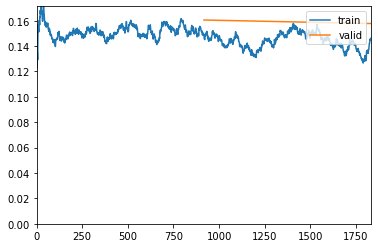

In [52]:
print('=' * 50, f" All Layers Unfrozen ", '=' * 50)
classifierModel.fit_one_cycle(2, max_lr=slice(1e-6,2e-6), moms=(0.8, 0.9))

In [53]:
classifierModel.show_results()

text,target,prediction
"[CLS] sub ##log ##arith ##mic distributed algorithms for lov ##as ##z local lemma , and the complexity hierarchy < join > locally check ##able labeling ( lc ##l ) problems include essentially all the classic problems of $ \ math ##sf { local } $ distributed algorithms . in a recent enl ##ight ##ening reve ##lation , chang and pet ##tie [ arxiv 170 ##4 . 06 ##29 ##7 ]",Computer Science,Computer Science
"[CLS] holog ##raph ##y and kos ##zu ##l duality : the example of the $ m ##2 $ brane < join > si li and author suggested in that , in some cases , the ads / cf ##t correspondence can be formulated in terms of the algebraic operation of kos ##zu ##l duality . in this paper this suggestion is checked explicitly for $ m ##2 $ brane ##s",Mathematics,Physics
"[CLS] whole planet coupling between climate , mantle , and core : implications for the evolution of rock ##y planets < join > earth ' s climate , mantle , and core interact over geo ##log ##ic timescale ##s . climate influences whether plate tect ##onic ##s can take place on a planet , with cool climate ##s being favorable for plate tect ##onic ##s because they enhance stresses in",Physics,Physics
"[CLS] covering and til ##ing hyper ##graphs with tight cycles < join > given $ 3 \ le ##q k \ le ##q s $ , we say that a $ k $ - uniform hyper ##graph $ c ^ k _ s $ is a tight cycle on $ s $ vertices if there is a cyclic ordering of the vertices of $ c ^ k _ s $",Mathematics,Computer Science;Mathematics
"[CLS] what drives galactic magnet ##ism ? < join > we aim to use statistical analysis of a large number of various galaxies to probe , model , and understand relations between different galaxy properties and magnetic fields . we have compiled a sample of 55 galaxies including low - mass dwarf and mag ##ella ##nic - types , normal spiral ##s and several massive star ##burst ##s , and",Physics,Physics


In [54]:
class_probs = classifierModel.get_preds(DatasetType.Test)[0]

In [55]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = (class_probs > 0.4).byte().detach().cpu().numpy()
    
    sampler = [i for i in data_classifier.dl(ds_type).sampler]
    
    reverse_sampler = np.argsort(sampler)
    
    return preds[reverse_sampler, :]

preds = get_preds_as_nparray(DatasetType.Test)

In [56]:
submission = pd.read_csv('/kaggle/input/researchtopictags/sample.csv')

submission.iloc[:,1:] =  preds

submission.to_csv('submission.csv', index=False)

submission.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,1,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0


# References

https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L318

https://sgugger.github.io/the-1cycle-policy.html